In [1]:
import mira
import scanpy as sc
import anndata

In [2]:
import pyro

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

#assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(0)

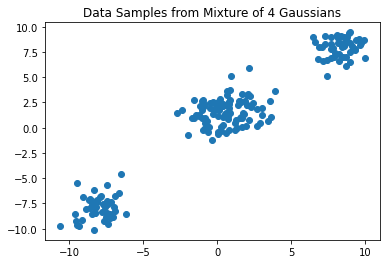

In [4]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [5]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [6]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)


def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [7]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.07
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

'''alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.94it/s]


'alpha = 1.5\ntrain(1000)\n\n# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights\nBayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))\n'

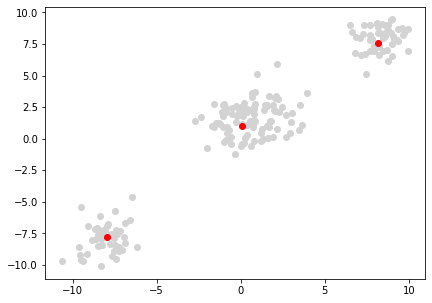

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="lightgrey")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

In [9]:
rna_data = anndata.read_h5ad('/liulab/alynch/projects/multiomics/e18_mouse_brain_10x_shared_rna_main_v4.ad')

OSError: Unable to open file (unable to open file: name = '/liulab/alynch/projects/multiomics/e18_mouse_brain_10x_shared_rna_main_v4.ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [113]:
from pyro.contrib.autoname import scope
from pyro import poutine

import mira.adata_interface.core as adi
import mira.adata_interface.topic_model as tmi
from math import ceil
from tqdm import trange
import pyro.distributions as dist
from torch.optim import Adam

In [114]:
@adi.wraps_modelfunc(fetch = tmi.fit_adata, 
    fill_kwargs=['features','highly_variable','endog_features','exog_features'])
def DP_get_learning_rate_bounds(self, num_epochs = 6, eval_every = 10, 
    lower_bound_lr = 1e-6, upper_bound_lr = 1,*,
    features, highly_variable, endog_features, exog_features):
    
    self._instantiate_model(
        features = features, highly_variable = highly_variable, 
        endog_features = endog_features, exog_features = exog_features,
    )

    self._get_dataset_statistics(endog_features, exog_features)

    n_batches = self.get_num_batches(endog_features.shape[0], self.batch_size)

    eval_steps = ceil((n_batches * num_epochs)/eval_every)

    learning_rates = np.exp(
            np.linspace(np.log(lower_bound_lr), 
            np.log(upper_bound_lr), 
            eval_steps+1))

    self.learning_rates = learning_rates

    def lr_function(e):
        return learning_rates[e]/learning_rates[0]

    scheduler = pyro.optim.LambdaLR({'optimizer': Adam, 
        'optim_args': {'lr': learning_rates[0], 'betas' : (0.95, 0.999)}, 
        'lr_lambda' : lr_function})

    self.svi = SVI(self.model, self.guide, scheduler, loss=Trace_ELBO())
    batches_complete, steps_complete, step_loss, samples_seen = 0,0,0,0
    learning_rate_losses = []

    #try:
    t = trange(eval_steps-2, desc = 'Learning rate range test', leave = True)
    _t = iter(t)

    for epoch in range(num_epochs + 1):

        #train step
        self.train()
        for batch in self._iterate_batches(endog_features = endog_features, 
                exog_features = exog_features, 
                batch_size = self.batch_size, bar = False):

            step_loss += float(self.svi.step(**batch, anneal_factor = 1.))
            batches_complete+=1
            samples_seen += batch['endog_features'].shape[0]

            if batches_complete % eval_every == 0 and batches_complete > 0:
                steps_complete+=1
                scheduler.step()
                learning_rate_losses.append(step_loss/(samples_seen * self.num_exog_features))
                step_loss, samples_seen = 0.0, 0
                try:
                    next(_t)
                except StopIteration:
                    break

    #except ValueError:
    #    logger.error('\nGradient overflow from too high learning rate, stopping test early.')

    self.gradient_lr = np.array(learning_rates[:len(learning_rate_losses)])
    self.gradient_loss = np.array(learning_rate_losses)

    return self.trim_learning_rate_bounds()

In [119]:
alpha = 1

@scope(prefix= 'rna')
def DP_model(self,*,endog_features, exog_features, read_depth, anneal_factor = 1.):
    
    #print(super(mira.topics.base.BaseModel, self))
    #theta_loc, theta_scale = super(mira.topics.base.BaseModel, self).guide()
    pyro.module("decoder", self.decoder)

    dispersion = pyro.param('dispersion', read_depth.new_ones(self.num_exog_features).to(self.device) * 5., constraint = constraints.positive)
    dispersion = dispersion.to(self.device)

    with pyro.plate("cells", endog_features.shape[0], dim = -2):
        with poutine.scale(None, anneal_factor):
            
            with pyro.plate("beta_plate", self.num_topics-1, dim = -1):
                beta = pyro.sample("beta", Beta(1, alpha))
                
            theta = mix_weights(beta)
            
            expr_rate = self.decoder(theta)

            read_scale = pyro.sample('read_depth', dist.LogNormal(torch.log(read_depth), 1.).to_event(1))

        logits = (read_scale * expr_rate).log() - (dispersion).log()
        X = pyro.sample('obs', dist.NegativeBinomial(total_count = dispersion, logits = logits).to_event(1), obs = exog_features)
            

@scope(prefix= 'rna')
def DP_guide(self,*,endog_features, exog_features, read_depth, anneal_factor = 1.):

    with pyro.plate("cells", endog_features.shape[0], dim = -2):

        theta_loc, theta_scale, rd_loc, rd_scale = self.encoder(endog_features, read_depth)

        with poutine.scale(None, anneal_factor):
            with pyro.plate("beta_plate", self.num_topics-1, dim=-1):
                q_beta = pyro.sample("beta", Beta(torch.ones(self.num_topics-1), theta_scale[:, :-1]))
            
            
            read_depth = pyro.sample(
                "read_depth", dist.LogNormal(rd_loc.reshape((-1,1)), rd_scale.reshape((-1,1))).to_event(1)
            )

In [126]:
rna_data = rna_data[np.random.permutation(len(rna_data))]

In [129]:
mira.topics.ExpressionTopicModel.model = DP_model
mira.topics.ExpressionTopicModel.guide = DP_guide
mira.topics.ExpressionTopicModel.get_learning_rate_bounds = DP_get_learning_rate_bounds

rna_model = mira.topics.ExpressionTopicModel(
    exogenous_key='highly_variable',
    endogenous_key = 'is_feature',
    num_topics = 25,
    encoder_dropout = 0.05,
    beta = 0.93,
    kl_strategy='monotonic',
    batch_size = 32
)

rna_model.get_learning_rate_bounds(rna_data, eval_every = 5)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: is_feature
Learning rate range test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [07:55<00:00, 13.20s/it]
INFO:mira.topic_model.base:Set learning rates to: (0.03265842230657605, 0.4493075983155576)


(0.03265842230657605, 0.4493075983155576)

INFO:mira.topic_model.base:Set learning rates to: (4.846939625825008, 0.272518834020234)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

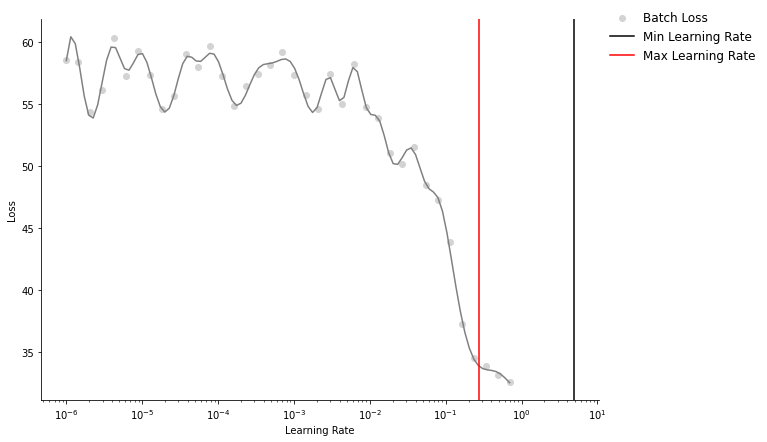

In [132]:
rna_model.trim_learning_rate_bounds(5,1)
rna_model.plot_learning_rate_bounds()